In [63]:
! pip install langgraph langchain dotenv 

In [64]:
! pip install langchain_huggingface

In [65]:
from langgraph.graph import StateGraph, START,END
from typing import TypedDict,Optional,List,Dict,Literal,Any
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser
from pydantic import BaseModel,Field
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate
import os

In [66]:
from dotenv import load_dotenv
load_dotenv()

True

In [67]:
class MemoryState(TypedDict):
    messages:List[Dict[str,str]]
    all_messages:str
    preferences:List[str]
    emotional_pattrens:list[str]
    facts:list[str]
    memory:Dict[str,Any]
    
    

In [68]:
def extract(state:MemoryState):
    all_msg="\n".join(msg["content"] for msg in state["messages"] if msg["role"]=="user")
    
    return {"all_messages":all_msg}


In [69]:
def load_preference(state: MemoryState):
    text = state["all_messages"]

    class Pattern(BaseModel):
        preferences: List[str] = Field(default_factory=list)

    parser = PydanticOutputParser(pydantic_object=Pattern)

    # LLM
    llm = HuggingFaceEndpoint(
        repo_id="openai/gpt-oss-20b",
        temperature=0.0,
        task="text-generation"
    )
    model = ChatHuggingFace(llm=llm)

    # Prompt
    prompt = PromptTemplate(template="""Extract the user's stable preferences from the conversation below.Return ONLY valid JSON that matches this format:{format_instructions} Conversation text:{text}""",
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()})

    chain = prompt | model | parser

    try:
        result = chain.invoke({"text": text})
        return {"preferences": result.preferences}

    except Exception as e:
        print("Error parsing output:", e)

        # Get raw model output to debug
        raw_output = (prompt | model).invoke({"text": text})
        print("Raw output:", raw_output)

        return {"preferences": []}


In [70]:
def emotional_pattrens(state: MemoryState):
    text = state["all_messages"]

    # Define Pydantic model
    class EmotionPattern(BaseModel):
        emotional_pattrens: List[str] = Field(default_factory=list)

    parser = PydanticOutputParser(pydantic_object=EmotionPattern)

    # HuggingFace LLM setup
    llm = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b",temperature=0.0,task="text-generation")
    model = ChatHuggingFace(llm=llm)

    # Prompt for LLM
    prompt = PromptTemplate(template="""Extract user emotions from the text below. Return ONLY a valid JSON object with a key "emotional_pattrens" as a list of strings.
                            Text:
        {text} {format_instructions} """,
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | model | parser

    try:
        result = chain.invoke({"text": text})
        return {"emotional_pattrens": result.emotional_pattrens}
    except Exception as e:
        print("Error parsing output:", e)
        raw_output = chain.invoke({"text": text}, return_raw=True)
        print("Raw output:", raw_output)
        return {"emotional_pattrens": []}


In [71]:
def load_facts(state: MemoryState):
    text = state["all_messages"]

    # Define Pydantic model
    class FactsPattern(BaseModel):
        facts: List[str] = Field(default_factory=list)

    parser = PydanticOutputParser(pydantic_object=FactsPattern)

    # HuggingFace LLM setup
    llm = HuggingFaceEndpoint(
        repo_id="openai/gpt-oss-20b",
        temperature=0.0,
        task="text-generation"
    )
    model = ChatHuggingFace(llm=llm)

    # Prompt for LLM
    prompt = PromptTemplate(template="""Extract objective facts from the text below.Return ONLY a valid JSON object with a key "facts" as a list of strings.
        Text: {text} {format_instructions}""",
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()})

    chain = prompt | model | parser

    try:
        result = chain.invoke({"text": text})
        return {"facts": result.facts}
    except Exception as e:
        print("Error parsing output:", e)
        raw_output = chain.invoke({"text": text}, return_raw=True)
        print("Raw output:", raw_output)
        return {"facts": []}


In [72]:
import json

In [73]:
def save_memory(state:MemoryState):
    preferences=state["preferences"]
    facts=state["facts"]
    emotional_pattrens=state["emotional_pattrens"]
    
    memory_data = {
        "preferences": preferences,
        "emotional_pattrens":emotional_pattrens,
        "facts":facts
    }
    
    with open("memory.json","w") as f:
        json.dump(memory_data,f,indent=2)
        
    return {"memory":memory_data}
    

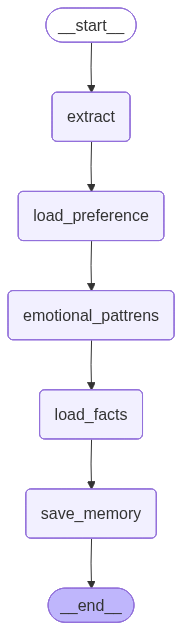

In [74]:
graph=StateGraph(MemoryState)

graph.add_node("extract",extract)
graph.add_node("load_preference",load_preference)
graph.add_node("emotional_pattrens",emotional_pattrens)
graph.add_node("load_facts",load_facts)
graph.add_node("save_memory",save_memory)

graph.add_edge(START,"extract")
graph.add_edge("extract","load_preference")
graph.add_edge("load_preference","emotional_pattrens")
graph.add_edge("emotional_pattrens","load_facts")
graph.add_edge("load_facts","save_memory")
graph.add_edge("save_memory",END)


workflow=graph.compile()
workflow
    

In [75]:
initial_state={"messages": [
    {"role": "user", "content": "I love eating Italian food and pizza."},
    {"role": "user", "content": "I usually wake up at 6 AM every day."},
    {"role": "user", "content": "I feel stressed whenever deadlines approach."},
    {"role": "user", "content": "I enjoy watching sci-fi movies in my free time."},
    {"role": "user", "content": "I am an introverted person and like quiet places."},
    {"role": "user", "content": "I like listening to classical music while working."},
    {"role": "user", "content": "I live in New York and work as a software engineer."},
    {"role": "user", "content": "I prefer working at night instead of mornings."},
    {"role": "user", "content": "I am allergic to peanuts and always avoid them."},
    {"role": "user", "content": "I feel excited when learning new programming languages."}
]}


In [76]:
output=workflow.invoke(initial_state)
print(output["preferences"])
print(output["emotional_pattrens"])
print(output["facts"])


['Italian food and pizza', 'watching sci-fi movies', 'quiet places', 'classical music while working', 'working at night', 'avoiding peanuts', 'learning new programming languages']
['love', 'stress', 'excitement', 'enjoyment', 'calm']
['I usually wake up at 6 AM every day.', 'I live in New York and work as a software engineer.', 'I prefer working at night instead of mornings.', 'I am allergic to peanuts and always avoid them.']


In [77]:
from typing import TypedDict, List, Any, Dict, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
class PersonalityState(TypedDict):
    messages:Annotated[List[BaseMessage],add_messages]   
    memory: Dict[str,Any]  
    preference_extracted:List[str]  
    facts_extracted:List[str]
    emotions_extracted:List[str]
    tone:str                                                 
    base_response: str                    
    final_response: str 

In [ ]:

MEMORY_FILE = "memory.json"

def load_memory_file() -> Dict[str, Any]:
    """Load memory.json if exists, else return empty structured memory."""
    with open(MEMORY_FILE, "r") as f:
        try:
            return json.load(f)
        except Exception:
            return {"preferences": {},"facts": {},"emotional_patterns": {}}
        
def save_memory_file(memory: Dict[str, Any]):
    with open(MEMORY_FILE, "w") as f:
        json.dump(memory, f, indent=4)

def retriever_memory(state:PersonalityState):
    memory=load_memory_file()
    
    return {"memory":memory}

In [ ]:

from src.Personality.llm.llm import model
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel,Field
from typing import Literal,List
from langchain_core.output_parsers import PydanticOutputParser

def extract_emotions(state: PersonalityState):
    
    message = state["messages"][-1].content
    
    class Emotion(BaseModel):
        emotions:List[str]=Field(default_factory=list)
    
    parser = PydanticOutputParser(pydantic_object=Emotion)
    
    prompt = PromptTemplate(template="""Extract the user's stable emotiona from the following message:{message} below.Return ONLY valid JSON that matches this format:{format_instructions}""",
        input_variables=["message"],
        partial_variables={"format_instructions": parser.get_format_instructions()})
    
    chain=prompt|model|parser
    
    result=chain.invoke({"message":message})
    
    return {"emotions_extracted":result.emotions}

In [ ]:
def generate_neutral_response(state:PersonalityState):
    
    message=state["messages"][-1].content
    
    prompt=PromptTemplate(template="""You are a helpful assistant. Given the user's message below, produce a concise helpful reply.
    Do NOT adopt any specific persona or unusual tone — neutral and informative.user_message:{user_message}""",input_variables=["user_message"])
    
    llm = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b",temperature=0.7,task="text-generation")
    model = ChatHuggingFace(llm=llm)
    
    parser=StrOutputParser()
    
    chain=prompt|model|parser
    
    result=chain.invoke({"user_message":message})
    
    return {"base_response":result}
    

In [ ]:
def apply_personality(state: PersonalityState):
    """
    Rewrites the neutral response into the requested tone using memory to personalize.
    """
    tone = state["tone"]
    memory = state["memory"]
    neutral = state["base_response"]

    # Build a persona instruction depending on the tone
    tone_instructions = {
        "calm_mentor": "Rewrite the reply so it sounds like a calm, supportive mentor. Keep it gentle, encouraging, and slightly explanatory.",
        "witty_friend": "Rewrite the reply to sound like a witty, playful friend. Keep it light, humorous, and brief.",
        "therapist": "Rewrite the reply to sound like a therapist: reflective, empathetic, non-judgmental, and supportive.",
        "concise_professional": "Rewrite the reply to be concise and professional, suitable for workplace communication."
    }

    # FIX 1: Get actual tone
    instr = tone_instructions.get(tone, "")

    prompt = PromptTemplate(template="""You are a personality transformer.User memory:{memory}Base reply:{base}Task: {instr}Rules:
    - Preserve the original meaning of the base reply.
    - Personalize the reply using the memory if relevant.
    - Do NOT invent new facts.
    - Output only the rewritten reply.""",
        input_variables=["base", "instr", "memory"])
    
    llm = HuggingFaceEndpoint(
        repo_id="openai/gpt-oss-20b",
        temperature=0.7,
        task="text-generation"
    )
    model = ChatHuggingFace(llm=llm)

    chain = prompt | model | StrOutputParser()

    final = chain.invoke({
        "base": neutral,
        "instr": instr,
        "memory": memory
    })

    return {"final_response": final}

In [ ]:

def check_condition(state:PersonalityState)->Literal["apply","skip"]:
    if state["tone"]==None:
        return "skip"
    else:
        return "apply"

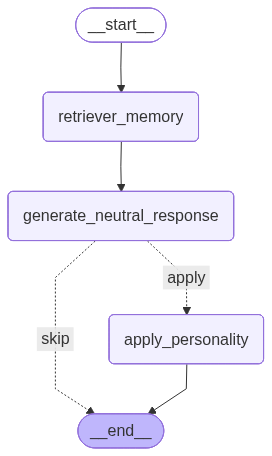

In [ ]:
graph=StateGraph(PersonalityState)
graph.add_node("retriever_memory",retriever_memory)
graph.add_node("generate_neutral_response",generate_neutral_response)
graph.add_node("apply_personality",apply_personality)

graph.add_edge(START,"retriever_memory")
graph.add_edge("retriever_memory","generate_neutral_response")
graph.add_conditional_edges("generate_neutral_response",check_condition,{"skip":END,"apply":"apply_personality"})
graph.add_edge("generate_neutral_response","apply_personality")
graph.add_edge("generate_neutral_response",END)
graph.add_edge("apply_personality",END)

workflow=graph.compile()
workflow

In [ ]:
from langchain_core.messages import HumanMessage

In [ ]:
output=workflow.invoke({"messages":HumanMessage(content="I am so stressed about exams"),"tone":None})
print(output)
output["base_response"]
output["final_response"]

{'messages': [HumanMessage(content='I am so stressed about exams', additional_kwargs={}, response_metadata={}, id='6b8d6543-58a4-4d94-864a-93d9f8692d39')], 'memory': {'preferences': ['Italian food and pizza', 'wakes up at 6 AM', 'stressed by deadlines', 'likes sci-fi movies', 'introverted, prefers quiet places', 'listens to classical music while working', 'lives in New York, software engineer', 'prefers night work over mornings', 'allergic to peanuts, avoids them', 'excited by learning new programming languages'], 'emotional_pattrens': ['love', 'stressed', 'enjoyment', 'excitement'], 'facts': ['wakes up at 6 AM every day', 'lives in New York', 'works as a software engineer', 'is allergic to peanuts', 'avoids peanuts']}, 'tone': None, 'base_response': 'I’m sorry you’re feeling so overwhelmed. Here are a few quick steps that might help:\n\n1. **Make a realistic schedule**  \n   • List all exams and major assignments.  \n   • Break each subject into smaller study blocks (e.g., 30–45\u202f

'I’m sorry you’re feeling so overwhelmed. Here are a few quick steps that might help:\n\n1. **Make a realistic schedule**  \n   • List all project deadlines and major milestones.  \n   • Break each task into smaller work blocks (e.g., 30–45\u202fmin) with 5‑minute breaks in between.  \n   • Since you’re an introvert who prefers quiet places and likes to work at night,'

In [ ]:
output["final_response"]

'I’m sorry you’re feeling so overwhelmed. Here are a few quick steps that might help:\n\n1. **Make a realistic schedule**  \n   • List all project deadlines and major milestones.  \n   • Break each task into smaller work blocks (e.g., 30–45\u202fmin) with 5‑minute breaks in between.  \n   • Since you’re an introvert who prefers quiet places and likes to work at night,'

In [ ]:
output["base_response"]

'I’m sorry you’re feeling so overwhelmed. Here are a few quick steps that might help:\n\n1. **Make a realistic schedule**  \n   • List all exams and major assignments.  \n   • Break each subject into smaller study blocks (e.g., 30–45\u202fmin) with short 5‑minute breaks in between.  \n   • Set a firm “study‑end” time each day to give yourself a mental break.\n\n2. **Prioritize active learning**  \n   • Use flashcards, practice problems, or teaching the material to someone else.  \n   • Focus on the concepts you find most difficult first, when your energy is highest.\n\n3. **Take care of the basics**  \n   • Aim for 7–8\u202fhours of sleep per night.  \n   • Eat balanced meals and stay hydrated.  \n   • Do a 5‑minute breathing or stretching routine whenever you feel a spike in anxiety.\n\n4. **Short‑term stress relief**  \n   • Practice a quick grounding exercise: 4‑7‑8 breathing (inhale 4\u202fs, hold 7\u202fs, exhale 8\u202fs).  \n   • If you’re stuck, step away for 5\u202fmin—walk, l

In [ ]:
output=workflow.invoke({"messages":HumanMessage(content="I am so stressed about exams"),"tone":"calm_mentor"})
print(output)
output["base_response"]
output["final_response"]

{'messages': [HumanMessage(content='I am so stressed about exams', additional_kwargs={}, response_metadata={}, id='88155766-cdc8-4784-92ab-cfc282b30436')], 'memory': {'preferences': ['Italian food and pizza', 'wakes up at 6 AM', 'stressed by deadlines', 'likes sci-fi movies', 'introverted, prefers quiet places', 'listens to classical music while working', 'lives in New York, software engineer', 'prefers night work over mornings', 'allergic to peanuts, avoids them', 'excited by learning new programming languages'], 'emotional_pattrens': ['love', 'stressed', 'enjoyment', 'excitement'], 'facts': ['wakes up at 6 AM every day', 'lives in New York', 'works as a software engineer', 'is allergic to peanuts', 'avoids peanuts']}, 'tone': 'calm_mentor', 'base_response': 'I’m sorry you’re feeling stressed. Here are a few quick strategies that might help:\n\n1. **Make a realistic study schedule**  \n   • Break your material into chunks (e.g., 45‑minute study blocks).  \n   • Include short breaks (5

'I hear how stressful deadlines can feel, and I’m here to help you find a calm rhythm that works for you.\n\n1. **Build a realistic schedule**  \n   - Since you’re up at 6\u202fa.m. but feel more productive at night, try setting aside a short “morning prep” slot—maybe 15–20\u202fminutes of light review or planning—then dive into deeper work when the city quiets down.  \n   - Break your study time into 45‑minute blocks with 5‑to‑10‑minute breaks. This keeps the mind fresh without forcing long, exhausting sessions.\n\n2. **Prioritize what matters most**  \n   - List the topics that carry the most weight or feel most challenging. Tackle those first while your focus is strongest.  \n   - When you finish a tough section, reward yourself with a quiet moment of classical music or a short walk in a nearby park—something that helps you unwind without overstimulating.\n\n3. **Use active learning**  \n   - Test yourself with flashcards, practice problems, or by explaining the material to an imagi

In [ ]:
print(output["base_response"])

I’m sorry you’re feeling stressed. Here are a few quick strategies that might help:

1. **Make a realistic study schedule**  
   • Break your material into chunks (e.g., 45‑minute study blocks).  
   • Include short breaks (5–10 min) after each block to prevent burnout.  

2. **Prioritize tasks**  
   • List the topics that carry the most weight or that you find most challenging.  
   • Tackle those first when your focus is strongest.

3. **Use active learning techniques**  
   • Test yourself with flashcards, practice problems, or teaching the material to someone else.  
   • Summarize key points in your own words.

4. **Take care of your body**  
   • Aim for 7–9 hours of sleep each night; sleep is crucial for memory consolidation.  
   • Eat balanced meals and stay hydrated.  
   • Incorporate short walks or light stretching to reduce tension.

5. **Practice relaxation**  
   • Try deep‑breathing exercises (inhale 4 s, hold 4 s, exhale 6 s).  
   • Even a 5‑minute meditation or prog

In [ ]:
print(output["final_response"])

I hear how stressful deadlines can feel, and I’m here to help you find a calm rhythm that works for you.

1. **Build a realistic schedule**  
   - Since you’re up at 6 a.m. but feel more productive at night, try setting aside a short “morning prep” slot—maybe 15–20 minutes of light review or planning—then dive into deeper work when the city quiets down.  
   - Break your study time into 45‑minute blocks with 5‑to‑10‑minute breaks. This keeps the mind fresh without forcing long, exhausting sessions.

2. **Prioritize what matters most**  
   - List the topics that carry the most weight or feel most challenging. Tackle those first while your focus is strongest.  
   - When you finish a tough section, reward yourself with a quiet moment of classical music or a short walk in a nearby park—something that helps you unwind without overstimulating.

3. **Use active learning**  
   - Test yourself with flashcards, practice problems, or by explaining the material to an imaginary audience.  
   - 

In [ ]:
url =assignment---guppshupp-ldge9aq8pjruujnkmanxua